In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans
import numpy as np

In [3]:
class LoadData:
    def __init__(self, ds_name):
        self.ds_name = ds_name
    def get_embeddings(self):
        if self.ds_name == "20NEWS":
            print("Dataset 20NEWS loaded...")
            x = np.load("representations.npy").astype('float32')
            x = x / tf.expand_dims(tf.norm(x, ord=2, axis=-1), -1).numpy()
        elif self.ds_name == "BBC":
            x = np.load("representations_bbc.npy").astype('float32')
            x = x / tf.expand_dims(tf.norm(x, ord=2, axis=-1), -1).numpy()
        elif self.ds_name =="Kpris":
            x = np.load("representations_kpris.npy").astype('float32')
            x = x / tf.expand_dims(tf.norm(x, ord=2, axis=-1), -1).numpy()
        return x

In [4]:
class Cluster:
    def __init__(self, ds_name, epochs, pretrain_batch_size, batch_size, input_shape, hidden_units):
        self.ds_name = ds_name
        self.epochs = epochs
        self.pretrain_batch_size = pretrain_batch_size
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.hidden_units = hidden_units
        
    def model_base(self, load_weights=True):
        input_shape = self.input_shape
        init = 'uniform'
        activation = 'relu'
        input = layers.Input(shape=input_shape)
        x = layers.Dense(500, activation=activation, kernel_initializer=init)(input)
        x = layers.Dense(500, activation=activation, kernel_initializer=init)(x)
        x = layers.Dense(2000, activation=activation, kernel_initializer=init)(x)
        x = layers.Dense(self.hidden_units, activation=activation, kernel_initializer=init)(x)
        h = x
        x = layers.Dense(2000, activation=activation, kernel_initializer=init)(x)
        x = layers.Dense(500, activation=activation, kernel_initializer=init)(x)
        x = layers.Dense(500, activation=activation, kernel_initializer=init)(x)
        y = layers.Dense(input_shape, activation=activation, kernel_initializer=init)(x)
        output = layers.Concatenate()([h, y])
        model = Model(inputs=input, outputs=output)
        if load_weights:
            model.load_weights(f'weight_base_{self.ds_name}.h5')
        print('model_conv: weights was loaded')
        return model
    
    def loss_train_base(self, y_true, y_pred):
        y_true = layers.Flatten()(y_true)
        y_pred = y_pred[:, self.hidden_units:]
        return losses.mse(y_true, y_pred)
    
    def train_base(self, ds_xx):
        model = self.model_base(load_weights=False)
        model.compile(optimizer='adam', loss=self.loss_train_base)
        model.fit(ds_xx, epochs=self.epochs, verbose=2)
        model.save_weights(f'weight_base_{self.ds_name}.h5')
    def optimized_kmeans(self, H):
        import matplotlib.pyplot as plt
        vals = []
        for i in range(1, 20 + 1):
            k_means = KMeans(n_clusters=i, init='k-means++', verbose=0, max_iter=100000)
            k_means.fit(H)
            vals.append(k_means.inertia_)
        plt.title("Optimum k value:")
        plt.plot([i for i in range(1, 20+1)], vals)

    def train(self, H, k):
        kmeans = KMeans(n_clusters=k, init='k-means++',verbose=1,max_iter=10000)
        y_pred = kmeans.fit_predict(H)
        return y_pred, kmeans
        

In [33]:
ds_name = 'BBC'
loader = LoadData(ds_name)
x = loader.get_embeddings()
epochs, pretrain_batch_size, batch_size, input_shape, hidden_units = 500, 256, 256, 768, 10
c = Cluster(ds_name, epochs, pretrain_batch_size, batch_size, input_shape, hidden_units)
ds_xx = tf.data.Dataset.from_tensor_slices((x, x)).batch(pretrain_batch_size)
c.train_base(ds_xx)

model_conv: weights was loaded
Epoch 1/500
9/9 - 1s - loss: 0.0012 - 856ms/epoch - 95ms/step
Epoch 2/500
9/9 - 0s - loss: 9.3236e-04 - 378ms/epoch - 42ms/step
Epoch 3/500
9/9 - 0s - loss: 8.8783e-04 - 351ms/epoch - 39ms/step
Epoch 4/500
9/9 - 0s - loss: 8.8113e-04 - 377ms/epoch - 42ms/step
Epoch 5/500
9/9 - 0s - loss: 8.7597e-04 - 350ms/epoch - 39ms/step
Epoch 6/500
9/9 - 0s - loss: 8.7481e-04 - 368ms/epoch - 41ms/step
Epoch 7/500
9/9 - 0s - loss: 8.7364e-04 - 373ms/epoch - 41ms/step
Epoch 8/500
9/9 - 0s - loss: 8.7352e-04 - 366ms/epoch - 41ms/step
Epoch 9/500
9/9 - 0s - loss: 8.7344e-04 - 365ms/epoch - 41ms/step
Epoch 10/500
9/9 - 0s - loss: 8.7290e-04 - 362ms/epoch - 40ms/step
Epoch 11/500
9/9 - 0s - loss: 8.7201e-04 - 375ms/epoch - 42ms/step
Epoch 12/500
9/9 - 0s - loss: 8.7199e-04 - 389ms/epoch - 43ms/step
Epoch 13/500
9/9 - 0s - loss: 8.7194e-04 - 385ms/epoch - 43ms/step
Epoch 14/500
9/9 - 0s - loss: 8.7191e-04 - 404ms/epoch - 45ms/step
Epoch 15/500
9/9 - 0s - loss: 8.7189e-04 - 3

Epoch 123/500
9/9 - 0s - loss: 7.3695e-04 - 416ms/epoch - 46ms/step
Epoch 124/500
9/9 - 0s - loss: 7.3666e-04 - 425ms/epoch - 47ms/step
Epoch 125/500
9/9 - 0s - loss: 7.3658e-04 - 414ms/epoch - 46ms/step
Epoch 126/500
9/9 - 0s - loss: 7.3629e-04 - 435ms/epoch - 48ms/step
Epoch 127/500
9/9 - 0s - loss: 7.3642e-04 - 416ms/epoch - 46ms/step
Epoch 128/500
9/9 - 0s - loss: 7.3687e-04 - 430ms/epoch - 48ms/step
Epoch 129/500
9/9 - 0s - loss: 7.3728e-04 - 410ms/epoch - 46ms/step
Epoch 130/500
9/9 - 0s - loss: 7.3473e-04 - 419ms/epoch - 47ms/step
Epoch 131/500
9/9 - 0s - loss: 7.3459e-04 - 401ms/epoch - 45ms/step
Epoch 132/500
9/9 - 0s - loss: 7.3388e-04 - 449ms/epoch - 50ms/step
Epoch 133/500
9/9 - 0s - loss: 7.3322e-04 - 411ms/epoch - 46ms/step
Epoch 134/500
9/9 - 0s - loss: 7.3072e-04 - 421ms/epoch - 47ms/step
Epoch 135/500
9/9 - 0s - loss: 7.2967e-04 - 429ms/epoch - 48ms/step
Epoch 136/500
9/9 - 0s - loss: 7.2919e-04 - 403ms/epoch - 45ms/step
Epoch 137/500
9/9 - 0s - loss: 7.2892e-04 - 423m

Epoch 244/500
9/9 - 0s - loss: 7.1057e-04 - 480ms/epoch - 53ms/step
Epoch 245/500
9/9 - 0s - loss: 7.1056e-04 - 480ms/epoch - 53ms/step
Epoch 246/500
9/9 - 0s - loss: 7.1080e-04 - 486ms/epoch - 54ms/step
Epoch 247/500
9/9 - 1s - loss: 7.1068e-04 - 517ms/epoch - 57ms/step
Epoch 248/500
9/9 - 0s - loss: 7.1113e-04 - 476ms/epoch - 53ms/step
Epoch 249/500
9/9 - 0s - loss: 7.1109e-04 - 494ms/epoch - 55ms/step
Epoch 250/500
9/9 - 1s - loss: 7.1152e-04 - 538ms/epoch - 60ms/step
Epoch 251/500
9/9 - 0s - loss: 7.1132e-04 - 481ms/epoch - 53ms/step
Epoch 252/500
9/9 - 1s - loss: 7.1182e-04 - 509ms/epoch - 57ms/step
Epoch 253/500
9/9 - 0s - loss: 7.1194e-04 - 496ms/epoch - 55ms/step
Epoch 254/500
9/9 - 1s - loss: 7.1205e-04 - 526ms/epoch - 58ms/step
Epoch 255/500
9/9 - 0s - loss: 7.1170e-04 - 484ms/epoch - 54ms/step
Epoch 256/500
9/9 - 0s - loss: 7.1088e-04 - 490ms/epoch - 54ms/step
Epoch 257/500
9/9 - 0s - loss: 7.1071e-04 - 482ms/epoch - 54ms/step
Epoch 258/500
9/9 - 0s - loss: 7.1074e-04 - 473m

Epoch 365/500
9/9 - 0s - loss: 7.0767e-04 - 484ms/epoch - 54ms/step
Epoch 366/500
9/9 - 1s - loss: 7.0720e-04 - 507ms/epoch - 56ms/step
Epoch 367/500
9/9 - 0s - loss: 7.0718e-04 - 453ms/epoch - 50ms/step
Epoch 368/500
9/9 - 0s - loss: 7.0713e-04 - 477ms/epoch - 53ms/step
Epoch 369/500
9/9 - 0s - loss: 7.0638e-04 - 480ms/epoch - 53ms/step
Epoch 370/500
9/9 - 0s - loss: 7.0758e-04 - 480ms/epoch - 53ms/step
Epoch 371/500
9/9 - 0s - loss: 7.0874e-04 - 469ms/epoch - 52ms/step
Epoch 372/500
9/9 - 0s - loss: 7.0803e-04 - 481ms/epoch - 53ms/step
Epoch 373/500
9/9 - 0s - loss: 7.0817e-04 - 485ms/epoch - 54ms/step
Epoch 374/500
9/9 - 1s - loss: 7.0754e-04 - 514ms/epoch - 57ms/step
Epoch 375/500
9/9 - 1s - loss: 7.0701e-04 - 506ms/epoch - 56ms/step
Epoch 376/500
9/9 - 0s - loss: 7.0751e-04 - 498ms/epoch - 55ms/step
Epoch 377/500
9/9 - 0s - loss: 7.0666e-04 - 475ms/epoch - 53ms/step
Epoch 378/500
9/9 - 1s - loss: 7.0739e-04 - 561ms/epoch - 62ms/step
Epoch 379/500
9/9 - 0s - loss: 7.0743e-04 - 483m

Epoch 486/500
9/9 - 0s - loss: 7.0297e-04 - 487ms/epoch - 54ms/step
Epoch 487/500
9/9 - 0s - loss: 7.0290e-04 - 454ms/epoch - 50ms/step
Epoch 488/500
9/9 - 0s - loss: 7.0348e-04 - 476ms/epoch - 53ms/step
Epoch 489/500
9/9 - 0s - loss: 7.0400e-04 - 455ms/epoch - 51ms/step
Epoch 490/500
9/9 - 0s - loss: 7.0379e-04 - 472ms/epoch - 52ms/step
Epoch 491/500
9/9 - 0s - loss: 7.0346e-04 - 491ms/epoch - 55ms/step
Epoch 492/500
9/9 - 0s - loss: 7.0281e-04 - 458ms/epoch - 51ms/step
Epoch 493/500
9/9 - 0s - loss: 7.0340e-04 - 453ms/epoch - 50ms/step
Epoch 494/500
9/9 - 0s - loss: 7.0313e-04 - 451ms/epoch - 50ms/step
Epoch 495/500
9/9 - 0s - loss: 7.0305e-04 - 454ms/epoch - 50ms/step
Epoch 496/500
9/9 - 0s - loss: 7.0276e-04 - 445ms/epoch - 49ms/step
Epoch 497/500
9/9 - 0s - loss: 7.0263e-04 - 432ms/epoch - 48ms/step
Epoch 498/500
9/9 - 0s - loss: 7.0258e-04 - 469ms/epoch - 52ms/step
Epoch 499/500
9/9 - 0s - loss: 7.0233e-04 - 489ms/epoch - 54ms/step
Epoch 500/500
9/9 - 0s - loss: 7.0208e-04 - 465m

model_conv: weights was loaded


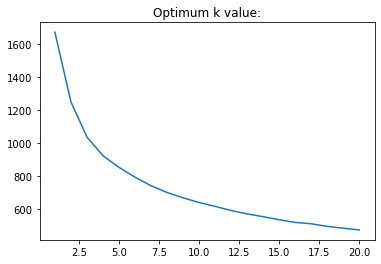

In [34]:
model = c.model_base()
H = model(x).numpy()[:, :hidden_units]
c.optimized_kmeans(H)

In [66]:
from sklearn.metrics import silhouette_score
s = []
for i in range(2, 11):
    y_pred, k_means = c.train(H, i)
    s.append(silhouette_score(H, y_pred))
k = [i+2 for i in range(len(s)) if s[i]==max(s)][0]

Initialization complete
Iteration 0, inertia 2409.48828125
Iteration 1, inertia 1310.487548828125
Iteration 2, inertia 1267.7203369140625
Iteration 3, inertia 1256.4136962890625
Iteration 4, inertia 1252.2359619140625
Iteration 5, inertia 1250.309326171875
Iteration 6, inertia 1249.584228515625
Iteration 7, inertia 1249.2581787109375
Iteration 8, inertia 1249.134521484375
Iteration 9, inertia 1249.1212158203125
Converged at iteration 9: center shift 1.3739945643465035e-06 within tolerance 7.514189183712006e-06.
Initialization complete
Iteration 0, inertia 1849.8958740234375
Iteration 1, inertia 1399.2503662109375
Iteration 2, inertia 1378.9805908203125
Iteration 3, inertia 1359.44970703125
Iteration 4, inertia 1332.831787109375
Iteration 5, inertia 1306.080810546875
Iteration 6, inertia 1279.747314453125
Iteration 7, inertia 1262.423583984375
Iteration 8, inertia 1254.9761962890625
Iteration 9, inertia 1252.38427734375
Iteration 10, inertia 1250.4716796875
Iteration 11, inertia 1249.53

Iteration 21, inertia 1036.6002197265625
Iteration 22, inertia 1036.585205078125
Converged at iteration 22: center shift 2.7705682441592216e-06 within tolerance 7.514189183712006e-06.
Initialization complete
Iteration 0, inertia 1673.231689453125
Iteration 1, inertia 1285.134033203125
Iteration 2, inertia 1147.14892578125
Iteration 3, inertia 1065.384521484375
Iteration 4, inertia 1044.4117431640625
Iteration 5, inertia 1039.09130859375
Iteration 6, inertia 1037.5389404296875
Iteration 7, inertia 1036.98583984375
Iteration 8, inertia 1036.825927734375
Iteration 9, inertia 1036.708251953125
Iteration 10, inertia 1036.6492919921875
Iteration 11, inertia 1036.623779296875
Iteration 12, inertia 1036.587890625
Converged at iteration 12: center shift 2.0713491721835453e-06 within tolerance 7.514189183712006e-06.
Initialization complete
Iteration 0, inertia 1418.0052490234375
Iteration 1, inertia 1051.1893310546875
Iteration 2, inertia 1040.1474609375
Iteration 3, inertia 1037.440673828125
It

Iteration 30, inertia 922.909912109375
Iteration 31, inertia 922.8345947265625
Iteration 32, inertia 922.7467041015625
Iteration 33, inertia 922.7188720703125
Iteration 34, inertia 922.710693359375
Iteration 35, inertia 922.7034912109375
Converged at iteration 35: center shift 5.785298071714351e-06 within tolerance 7.514189183712006e-06.
Initialization complete
Iteration 0, inertia 1396.143798828125
Iteration 1, inertia 1007.1614379882812
Iteration 2, inertia 956.3785400390625
Iteration 3, inertia 941.225830078125
Iteration 4, inertia 933.4175415039062
Iteration 5, inertia 928.5467529296875
Iteration 6, inertia 926.1377563476562
Iteration 7, inertia 924.228515625
Iteration 8, inertia 923.34716796875
Iteration 9, inertia 922.9320068359375
Iteration 10, inertia 922.7982177734375
Iteration 11, inertia 922.7672119140625
Iteration 12, inertia 922.7366943359375
Iteration 13, inertia 922.727783203125
Iteration 14, inertia 922.7212524414062
Converged at iteration 14: strict convergence.
Initia

Iteration 7, inertia 865.9776000976562
Iteration 8, inertia 862.792724609375
Iteration 9, inertia 860.3897094726562
Iteration 10, inertia 859.09716796875
Iteration 11, inertia 858.0982055664062
Iteration 12, inertia 857.4451293945312
Iteration 13, inertia 856.9019775390625
Iteration 14, inertia 856.5619506835938
Iteration 15, inertia 856.3856201171875
Iteration 16, inertia 856.3020629882812
Iteration 17, inertia 856.2034301757812
Iteration 18, inertia 856.0762329101562
Iteration 19, inertia 855.798828125
Iteration 20, inertia 855.6546630859375
Iteration 21, inertia 855.5573120117188
Iteration 22, inertia 855.5140380859375
Iteration 23, inertia 855.4794921875
Iteration 24, inertia 855.4676513671875
Iteration 25, inertia 855.4446411132812
Iteration 26, inertia 855.4100952148438
Iteration 27, inertia 855.391845703125
Iteration 28, inertia 855.3757934570312
Iteration 29, inertia 855.36669921875
Converged at iteration 29: center shift 4.757165697810706e-06 within tolerance 7.514189183712006

Iteration 5, inertia 815.0201416015625
Iteration 6, inertia 806.76513671875
Iteration 7, inertia 802.3005981445312
Iteration 8, inertia 800.0997924804688
Iteration 9, inertia 798.6893920898438
Iteration 10, inertia 798.091796875
Iteration 11, inertia 797.3597412109375
Iteration 12, inertia 796.2138061523438
Iteration 13, inertia 795.3103637695312
Iteration 14, inertia 794.6870727539062
Iteration 15, inertia 794.2454833984375
Iteration 16, inertia 793.8839721679688
Iteration 17, inertia 793.703369140625
Iteration 18, inertia 793.5781860351562
Iteration 19, inertia 793.32373046875
Iteration 20, inertia 792.9989624023438
Iteration 21, inertia 792.8895263671875
Iteration 22, inertia 792.843017578125
Iteration 23, inertia 792.80224609375
Iteration 24, inertia 792.7633056640625
Iteration 25, inertia 792.7489013671875
Converged at iteration 25: center shift 3.845785158773651e-06 within tolerance 7.514189183712006e-06.
Initialization complete
Iteration 0, inertia 1132.8873291015625
Iteration 1

Iteration 18, inertia 744.2376098632812
Iteration 19, inertia 743.9246215820312
Iteration 20, inertia 743.6591796875
Iteration 21, inertia 743.4385986328125
Iteration 22, inertia 743.1485595703125
Iteration 23, inertia 743.0321044921875
Iteration 24, inertia 742.9905395507812
Iteration 25, inertia 742.9286499023438
Iteration 26, inertia 742.8446044921875
Iteration 27, inertia 742.6806640625
Iteration 28, inertia 742.4822998046875
Iteration 29, inertia 742.2971801757812
Iteration 30, inertia 742.16259765625
Iteration 31, inertia 742.0745239257812
Iteration 32, inertia 742.01171875
Iteration 33, inertia 741.958251953125
Iteration 34, inertia 741.9270629882812
Iteration 35, inertia 741.91748046875
Iteration 36, inertia 741.9136962890625
Converged at iteration 36: strict convergence.
Initialization complete
Iteration 0, inertia 1105.634765625
Iteration 1, inertia 880.8265380859375
Iteration 2, inertia 826.2930908203125
Iteration 3, inertia 802.4492797851562
Iteration 4, inertia 790.3819580

Initialization complete
Iteration 0, inertia 1034.51025390625
Iteration 1, inertia 764.516845703125
Iteration 2, inertia 745.1717529296875
Iteration 3, inertia 736.0687255859375
Iteration 4, inertia 731.2227783203125
Iteration 5, inertia 728.5331420898438
Iteration 6, inertia 727.229736328125
Iteration 7, inertia 726.0467529296875
Iteration 8, inertia 724.4179077148438
Iteration 9, inertia 722.4552612304688
Iteration 10, inertia 720.8534545898438
Iteration 11, inertia 719.7205810546875
Iteration 12, inertia 719.1174926757812
Iteration 13, inertia 718.806396484375
Iteration 14, inertia 718.5516357421875
Iteration 15, inertia 718.099365234375
Iteration 16, inertia 717.4842529296875
Iteration 17, inertia 717.1311645507812
Iteration 18, inertia 716.699462890625
Iteration 19, inertia 716.22021484375
Iteration 20, inertia 715.5079956054688
Iteration 21, inertia 715.1136474609375
Iteration 22, inertia 714.9620971679688
Iteration 23, inertia 714.7794189453125
Iteration 24, inertia 714.37121582

Iteration 44, inertia 700.05908203125
Iteration 45, inertia 700.0471801757812
Iteration 46, inertia 700.0343627929688
Iteration 47, inertia 700.0151977539062
Iteration 48, inertia 700.0027465820312
Iteration 49, inertia 699.9827880859375
Iteration 50, inertia 699.9779052734375
Converged at iteration 50: strict convergence.
Initialization complete
Iteration 0, inertia 966.0791015625
Iteration 1, inertia 799.8030395507812
Iteration 2, inertia 772.7386474609375
Iteration 3, inertia 760.0982666015625
Iteration 4, inertia 751.1736450195312
Iteration 5, inertia 742.5146484375
Iteration 6, inertia 736.6102905273438
Iteration 7, inertia 734.088134765625
Iteration 8, inertia 732.5446166992188
Iteration 9, inertia 731.64111328125
Iteration 10, inertia 731.2867431640625
Iteration 11, inertia 731.0432739257812
Iteration 12, inertia 730.7533569335938
Iteration 13, inertia 730.5
Iteration 14, inertia 730.2713623046875
Iteration 15, inertia 729.9476318359375
Iteration 16, inertia 729.59130859375
Iter

Iteration 4, inertia 708.21435546875
Iteration 5, inertia 699.4744873046875
Iteration 6, inertia 693.6754760742188
Iteration 7, inertia 690.9256591796875
Iteration 8, inertia 689.6431884765625
Iteration 9, inertia 688.3758544921875
Iteration 10, inertia 687.3411254882812
Iteration 11, inertia 686.6172485351562
Iteration 12, inertia 685.92919921875
Iteration 13, inertia 685.07470703125
Iteration 14, inertia 683.8527221679688
Iteration 15, inertia 682.4412231445312
Iteration 16, inertia 681.276123046875
Iteration 17, inertia 680.403564453125
Iteration 18, inertia 679.5182495117188
Iteration 19, inertia 678.5463256835938
Iteration 20, inertia 677.1580810546875
Iteration 21, inertia 676.2423095703125
Iteration 22, inertia 675.5700073242188
Iteration 23, inertia 674.8609619140625
Iteration 24, inertia 674.1962890625
Iteration 25, inertia 673.5786743164062
Iteration 26, inertia 673.084716796875
Iteration 27, inertia 672.6846923828125
Iteration 28, inertia 672.446533203125
Iteration 29, inert

Initialization complete
Iteration 0, inertia 938.9176025390625
Iteration 1, inertia 739.1177368164062
Iteration 2, inertia 708.1657104492188
Iteration 3, inertia 694.0529174804688
Iteration 4, inertia 686.5177001953125
Iteration 5, inertia 681.481689453125
Iteration 6, inertia 677.5701904296875
Iteration 7, inertia 674.2425537109375
Iteration 8, inertia 670.9983520507812
Iteration 9, inertia 668.970458984375
Iteration 10, inertia 667.506103515625
Iteration 11, inertia 665.77197265625
Iteration 12, inertia 664.6917724609375
Iteration 13, inertia 663.6829223632812
Iteration 14, inertia 662.96728515625
Iteration 15, inertia 662.0181274414062
Iteration 16, inertia 661.0086059570312
Iteration 17, inertia 659.975341796875
Iteration 18, inertia 659.1312255859375
Iteration 19, inertia 658.529296875
Iteration 20, inertia 657.6818237304688
Iteration 21, inertia 656.9103393554688
Iteration 22, inertia 655.7974243164062
Iteration 23, inertia 654.925537109375
Iteration 24, inertia 654.2357788085938

Iteration 41, inertia 639.4707641601562
Iteration 42, inertia 639.3627319335938
Iteration 43, inertia 639.3303833007812
Iteration 44, inertia 639.2998657226562
Iteration 45, inertia 639.2789916992188
Iteration 46, inertia 639.270263671875
Converged at iteration 46: strict convergence.
Initialization complete
Iteration 0, inertia 863.3794555664062
Iteration 1, inertia 717.9281616210938
Iteration 2, inertia 689.1539306640625
Iteration 3, inertia 677.479248046875
Iteration 4, inertia 672.7725219726562
Iteration 5, inertia 670.0379028320312
Iteration 6, inertia 667.7915649414062
Iteration 7, inertia 665.30810546875
Iteration 8, inertia 662.7374267578125
Iteration 9, inertia 660.266357421875
Iteration 10, inertia 657.531005859375
Iteration 11, inertia 654.6206665039062
Iteration 12, inertia 652.7855834960938
Iteration 13, inertia 651.4725341796875
Iteration 14, inertia 650.2734985351562
Iteration 15, inertia 649.4750366210938
Iteration 16, inertia 648.7431030273438
Iteration 17, inertia 648

In [68]:
y_pred, k_means = c.train(H, k)

Initialization complete
Iteration 0, inertia 2260.684814453125
Iteration 1, inertia 1387.8465576171875
Iteration 2, inertia 1378.2862548828125
Iteration 3, inertia 1372.768310546875
Iteration 4, inertia 1367.57763671875
Iteration 5, inertia 1363.0450439453125
Iteration 6, inertia 1359.6531982421875
Iteration 7, inertia 1355.554443359375
Iteration 8, inertia 1348.6549072265625
Iteration 9, inertia 1339.792724609375
Iteration 10, inertia 1322.07666015625
Iteration 11, inertia 1297.707275390625
Iteration 12, inertia 1274.781494140625
Iteration 13, inertia 1260.07470703125
Iteration 14, inertia 1252.2857666015625
Iteration 15, inertia 1249.9267578125
Iteration 16, inertia 1249.247802734375
Iteration 17, inertia 1249.1697998046875
Converged at iteration 17: center shift 3.7783761399623472e-06 within tolerance 7.514189183712006e-06.
Initialization complete
Iteration 0, inertia 2181.890869140625
Iteration 1, inertia 1390.4576416015625
Iteration 2, inertia 1384.8238525390625
Iteration 3, inert

C:\Users\joani\anaconda3\envs\Doc\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\joani\anaconda3\envs\Doc\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\joani\anaconda3\envs\Doc\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


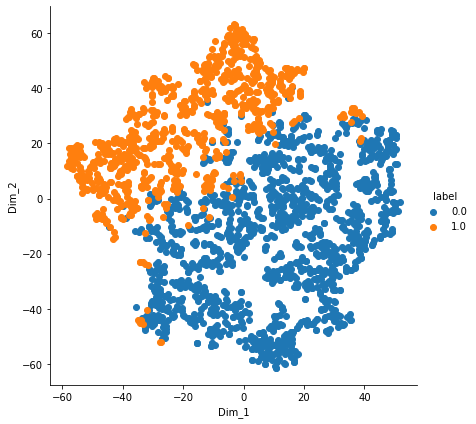

In [69]:
#t-sne
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(H)
tsne_data = np.vstack((tsne_data.T, y_pred)).T
tsne_df = pd.DataFrame(data = tsne_data,columns =("Dim_1", "Dim_2", "label"))
sns.FacetGrid(tsne_df, hue ="label", size = 6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [70]:
import spacy
import en_core_web_sm
import tomotopy as tp
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
stop_words.add('subject')
stop_words.add('http')
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 
nlp = en_core_web_sm.load()

In [71]:
class TopicModelling:
    def __init__(self,ds_name):
        self.ds_name = ds_name
        import os
        try:
            os.mkdir('TopicModels')
            os.mkdir('TopicModels/20NEWS')
            os.mkdir('TopicModels/BBC')
            os.mkdir('TopicModels/Kpris')
            print("Directory Generated")
        except FileExistsError:
            print("Directory already exists")
            
    def get_text(self):
        if self.ds_name == "20NEWS":
            from sklearn.datasets import fetch_20newsgroups
            _20news = fetch_20newsgroups(subset="all")
            data = _20news.data
        elif self.ds_name == "BBC":
            import pandas as pd
            df = pd.read_csv("bbc-news-data.csv",sep='\t')
            data = df["title"] + " " + df["content"]
        elif self.ds_name =="Kpris":
            import pandas as pd
            df = pd.read_csv("kpris_data.csv")
            data = df.abstract.str[:-3]
        return data
    
    def sort_data_to_clusters(self,data,clusters):
        cluster_data={}
        for cluster_num in range(0,len(clusters)):
            if clusters[cluster_num] not in cluster_data:
                cluster_data[clusters[cluster_num]]=[]
            cluster_data[clusters[cluster_num]].append(data[cluster_num])
        return cluster_data
    
    def topic_models(self,cluster_data,depth=3,rm_top=200,iterations=10):
        topicModels={}
        for cluster in cluster_data:
            topicModel = tp.HLDAModel(depth=depth,rm_top=rm_top)
            for doc in cluster_data[cluster]:
                if len(doc)>0:
                    if self.ds_name=="Kpris":
                        topicModel.add_doc([str(x) for x in nlp(doc)])
                    else:
                        topicModel.add_doc([str(x) for x in nlp(doc).ents])
            for counter in range(0, 100, iterations):
                topicModel.train(iterations)
            topicModels[cluster]=topicModel
        return topicModels
    
    def save_models(self,topic_models):
        if self.ds_name == "20NEWS":
            for model_cluster in topic_models:
                topic_models[model_cluster].save(f'TopicModels/20NEWS/20NEWS_HLDA_Topic_Model_cluser_{model_cluster}.bin')
        if self.ds_name == "BBC":
            for model_cluster in topic_models:
                topic_models[model_cluster].save(f'TopicModels/BBC/BBC_HLDA_Topic_Model_cluser_{model_cluster}.bin')
        if self.ds_name == "Kpris":
            for model_cluster in topic_models:
                topic_models[model_cluster].save(f'TopicModels/Kpris/Kpris_HLDA_Topic_Model_cluser_{model_cluster}.bin')
    
    def load_models(self,clusters):
        topicModels={}
        if self.ds_name == "20NEWS":
            for i in range(0,clusters):
                topicModels[i]=tp.HLDAModel.load(f'TopicModels/20NEWS/20NEWS_HLDA_Topic_Model_cluser_{i}.bin')
        if self.ds_name == "BBC":
            for i in range(0,clusters):
                topicModels[i]=tp.HLDAModel.load(f'TopicModels/BBC/BBC_HLDA_Topic_Model_cluser_{i}.bin')
        if self.ds_name == "Kpris":
            for i in range(0,clusters):
                topicModels[i]=tp.HLDAModel.load(f'TopicModels/Kpris/Kpris_HLDA_Topic_Model_cluser_{i}.bin')
            return topicModels
    
    def process_models(self,topic_models):
        stop_words = set(stopwords.words('english'))
        
        processed_topics={}
        for i in topic_models:
            processed_topics[i]=[]
            for k,l in topic_models[i].get_topic_words(0):
                if k:
                    processed_topics[i].append(k)
            for j in topic_models[i].children_topics(0):
                for k,l in topic_models[i].get_topic_words(j):
                    if k:
                        processed_topics[i].append(k)
        for i in processed_topics:
            processed_topics[i] = " ".join(processed_topics[i]).lower() #Lower-Casing
            processed_topics[i] = " ".join(s for s in processed_topics[i].split() if not any(c.isdigit() for c in s))
            processed_topics[i] = word_tokenize(processed_topics[i])
            processed_topics[i] = [w for w in processed_topics[i] if not w in stop_words]
            processed_topics[i] = [lemmatizer.lemmatize(word) for word in processed_topics[i]]
            processed_topics[i] = " ".join(processed_topics[i])
            processed_topics[i] = "".join(e for e in processed_topics[i] if e.isalnum() or e.isspace())
            processed_topics[i] = nlp(processed_topics[i]).ents
        return processed_topics

In [72]:
bbc = TopicModelling("BBC")

Directory already exists


In [73]:
text = bbc.get_text()
cluster_data = bbc.sort_data_to_clusters(text, y_pred)
tm = bbc.topic_models(cluster_data)


In [74]:
tmp = bbc.process_models(tm)

In [89]:
tmp[0]

(next month,
 april,
 south korea,
 european,
 european past year,
 northern ireland,
 british chamber commerce telegraph,
 national union,
 telegraph group,
 afternoon,
 coming month,
 mcdonald s halfhour,
 justin,
 timberlake quarter,
 kraft mcdonalds,
 two day,
 jack,
 miguel moratinos peter caruana,
 wilbur crossrail ken livingstone,
 goodrem green day missy,
 hundred,
 kerekou,
 two week,
 west african,
 duran duran,
 tomorrow,
 st fintian s jack,
 mike watt,
 next week,
 opec,
 bin shatwan north east mark,
 recent day,
 morgan citizen bank canal bank,
 chicago,
 africanamerican,
 morgan chase morgan bank,
 one,
 march least one,
 billy cfd fleetboston,
 three,
 columbia,
 billy elliot robin cook,
 mccreadie day sixth,
 last week,
 pentagon,
 michael douglas  toyota,
 american express,
 year decade,
 american express,
 african,
 entropia entropia,
 newcastle,
 benita johnson,
 hundred thousand,
 s m,
 canadian approximately,
 pharma s malibu,
 denmark,
 la henry reichhold,
 joey m

In [81]:
tmp[1]

(charlie hodgson josh lewsey lion,
 jonny wilkinson,
 two year,
 march five,
 india,
 august,
 two year ago earlier month,
 celebrex meldrum,
 mikoliunas livi,
 berra minute,
 lee miller,
 second,
 next decade,
 jordan,
 arab,
 blue yapp,
 bbc,
 ian,
 duncan jones dai young,
 season virgin radio virgin,
 past five year later year,
 mickey mouse,
 morrison,
 mark morrison,
 later diamond year ago,
 lita chorley scott murray,
 kamara martin harley,
 august,
 kharkov,
 alfaeco s,
 asia pacific,
 iraqi,
 september,
 five year three month ago onesixth,
 morrissey,
 united s,
 smith june,
 tomiyama,
 hollywood boulevard,
 chinese,
 bp,
 last week,
 many year final,
 three month,
 nbc,
 cleveland,
 rome,
 mexico,
 elizabeth blunt,
 november january,
 venezuelan chavez,
 vestey group,
 venezuela hato el charcote,
 maruti,
 last three month year earlier,
 colombia,
 half,
 united bank,
 united bank,
 africa nigeria,
 s elton sharon osbourne,
 year last year,
 elton john bastille fondation,
 two

In [106]:
data = ""
for i in tmp[0]:
    data = data + " " + str(i)

In [107]:
data2 = ""
for i in tmp[1]:
    data2 = data2 + " " + str(i)

In [157]:
remove_ents = ["DATE", "CARDINAL", "ORDINAL", "PERCENT", "TIME"]
def remove_unwanted_tags(text):
        x_spc= nlp(text)
        x_return= ''
        idx= 0
        idx_last_ent= 0
        len_last_ent= 0

        for i, ent in enumerate(x_spc.ents):
            idx= text.find(ent.text)
            if i == 0:
                x_return= text[0: idx]
            else:
                x_return= x_return + text[idx_last_ent+ len_last_ent: idx]

            if ent.ent_type_ not in remove_ents:
                x_return= x_return+ ent.text

            if i== len(x_spc.ents)-1:
                x_return= x_return+ text[idx+len(ent.text): ]

            len_last_ent= len(ent.text)
            idx_last_ent= idx

        x_return= x_return.lower()

        x_return= re.sub('[^\sa-z]', '', x_return)

        x_return= ' '.join([x for x in x_return.split(' ') if (len(x)> 1)])

        #displacy.render(x_spc, style= 'ent', jupyter= True)

        return x_return

In [158]:
def make_cloud(data):
    from wordcloud import WordCloud
    cloud = WordCloud().generate(data)
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(cloud)
    plt.show()

In [135]:
data

' next month april south korea european european past year northern ireland british chamber commerce telegraph national union telegraph group afternoon coming month mcdonald s halfhour justin timberlake quarter kraft mcdonalds two day jack miguel moratinos peter caruana wilbur crossrail ken livingstone goodrem green day missy hundred kerekou two week west african duran duran tomorrow st fintian s jack mike watt next week opec bin shatwan north east mark recent day morgan citizen bank canal bank chicago africanamerican morgan chase morgan bank one march least one billy cfd fleetboston three columbia billy elliot robin cook mccreadie day sixth last week pentagon michael douglas  toyota american express year decade american express african entropia entropia newcastle benita johnson hundred thousand s m canadian approximately pharma s malibu denmark la henry reichhold joey matt leblanc david blunkett guardian richard eyre marie leroi s swiss afghanistan three year diemont every year north 

In [136]:
final_data

'european british chamber commerce telegraph national union telegraph group afternoon mcdonald halfhour justin timberlake quarter kraft mcdonalds jack miguel moratinos peter caruana wilbur crossrail ken livingstone goodrem green day missy hundred kerekou west african year northern ireland british chamber commerce telegraph national union telegraph group afternoon coming month mcdonald halfhour justin timberlake quarter kraft mcdonalds two day jack miguel moratinos peter caruana wilbur crossrail ken livingstone goodrem green day missy hundred kerekou two week west african duran duran tomorrow st fintian jack mike watt opec bin shatwan north east mark recent day morgan citizen bank canal bank africanamerican morgan chase morgan bank one march least one billy cfd fleetboston columbia billy elliot robin cook pentagon michael douglas toyota american express american expressafrican duran duran tomorrow st fintian jack mike watt next week opec bin shatwan north east mark recent day morgan cit

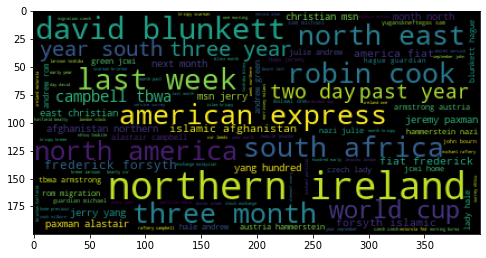

In [132]:
last_data = remove_unwanted_tags(final_data)
make_cloud(last_data)

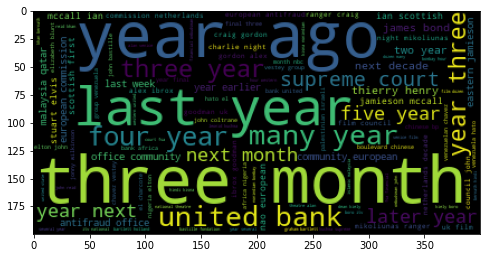

In [142]:
final_data2 = remove_unwanted_tags(data2)
make_cloud(final_data2)

In [183]:
types = [str(ent.text) for ent in nlp(final_data) if ent.ent_type_ not in remove_ents]
types2 = [str(ent.text) for ent in nlp(final_data2) if ent.ent_type_ not in remove_ents]

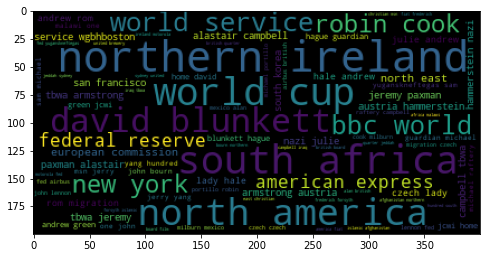

In [184]:
make_cloud(" ".join(types))

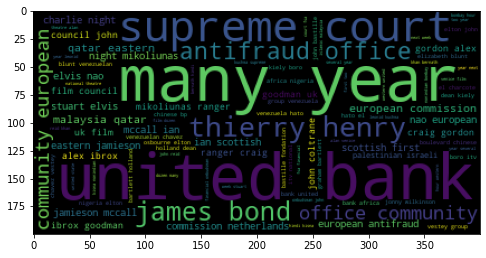

In [185]:
make_cloud(" ".join(types2))

Kpris

In [197]:
ds_name = 'Kpris'
loader = LoadData(ds_name)
x = loader.get_embeddings()
epochs, pretrain_batch_size, batch_size, input_shape, hidden_units = 100, 256, 256, 768, 10
c = Cluster(ds_name, epochs, pretrain_batch_size, batch_size, input_shape, hidden_units)
ds_xx = tf.data.Dataset.from_tensor_slices((x, x)).batch(pretrain_batch_size)
c.train_base(ds_xx)

model_conv: weights was loaded
Epoch 1/100
77/77 - 4s - loss: 9.0157e-04 - 4s/epoch - 50ms/step
Epoch 2/100
77/77 - 3s - loss: 8.3114e-04 - 3s/epoch - 44ms/step
Epoch 3/100
77/77 - 4s - loss: 7.6392e-04 - 4s/epoch - 49ms/step
Epoch 4/100
77/77 - 4s - loss: 7.4902e-04 - 4s/epoch - 51ms/step
Epoch 5/100
77/77 - 4s - loss: 7.4223e-04 - 4s/epoch - 52ms/step
Epoch 6/100
77/77 - 4s - loss: 7.4157e-04 - 4s/epoch - 52ms/step
Epoch 7/100
77/77 - 4s - loss: 7.3949e-04 - 4s/epoch - 54ms/step
Epoch 8/100
77/77 - 4s - loss: 7.3472e-04 - 4s/epoch - 55ms/step
Epoch 9/100
77/77 - 4s - loss: 7.2782e-04 - 4s/epoch - 53ms/step
Epoch 10/100
77/77 - 4s - loss: 7.2316e-04 - 4s/epoch - 52ms/step
Epoch 11/100
77/77 - 4s - loss: 7.2074e-04 - 4s/epoch - 51ms/step
Epoch 12/100
77/77 - 4s - loss: 7.2015e-04 - 4s/epoch - 53ms/step
Epoch 13/100
77/77 - 4s - loss: 7.1972e-04 - 4s/epoch - 57ms/step
Epoch 14/100
77/77 - 4s - loss: 7.1873e-04 - 4s/epoch - 56ms/step
Epoch 15/100
77/77 - 4s - loss: 7.1619e-04 - 4s/epoch 

model_conv: weights was loaded


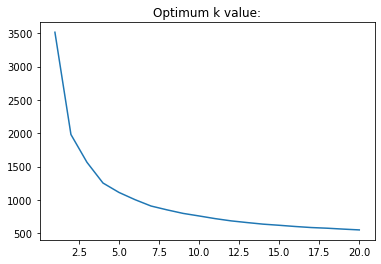

In [198]:
model = c.model_base()
H = model(x).numpy()[:, :hidden_units]
c.optimized_kmeans(H)

In [199]:
s = []
for i in range(2, 11):
    y_pred, k_means = c.train(H, i)
    s.append(silhouette_score(H, y_pred))
k = [i+2 for i in range(len(s)) if s[i]==max(s)][0]

Initialization complete
Iteration 0, inertia 4618.25146484375
Iteration 1, inertia 2010.622802734375
Iteration 2, inertia 1988.086669921875
Iteration 3, inertia 1982.8780517578125
Iteration 4, inertia 1981.508056640625
Iteration 5, inertia 1981.0257568359375
Iteration 6, inertia 1980.930908203125
Converged at iteration 6: center shift 1.0188566648139386e-06 within tolerance 1.7839688807725908e-06.
Initialization complete
Iteration 0, inertia 3683.3828125
Iteration 1, inertia 1991.4820556640625
Iteration 2, inertia 1982.0653076171875
Iteration 3, inertia 1981.2027587890625
Iteration 4, inertia 1980.948974609375
Iteration 5, inertia 1980.9208984375
Converged at iteration 5: center shift 6.142130928310507e-07 within tolerance 1.7839688807725908e-06.
Initialization complete
Iteration 0, inertia 4235.24169921875
Iteration 1, inertia 2966.713134765625
Iteration 2, inertia 2931.79931640625
Iteration 3, inertia 2804.8427734375
Iteration 4, inertia 2376.191162109375
Iteration 5, inertia 2021.21

Iteration 1, inertia 1708.182861328125
Iteration 2, inertia 1658.741943359375
Iteration 3, inertia 1645.87841796875
Iteration 4, inertia 1639.364013671875
Iteration 5, inertia 1631.6446533203125
Iteration 6, inertia 1623.0028076171875
Iteration 7, inertia 1615.1168212890625
Iteration 8, inertia 1606.982177734375
Iteration 9, inertia 1598.15771484375
Iteration 10, inertia 1586.8218994140625
Iteration 11, inertia 1575.8897705078125
Iteration 12, inertia 1569.226806640625
Iteration 13, inertia 1566.2591552734375
Iteration 14, inertia 1564.75341796875
Iteration 15, inertia 1564.1455078125
Iteration 16, inertia 1563.882568359375
Iteration 17, inertia 1563.79931640625
Iteration 18, inertia 1563.7772216796875
Converged at iteration 18: center shift 1.3356453791857348e-06 within tolerance 1.7839688807725908e-06.
Initialization complete
Iteration 0, inertia 1930.5926513671875
Iteration 1, inertia 1314.5423583984375
Iteration 2, inertia 1266.048583984375
Iteration 3, inertia 1258.0665283203125
I

Iteration 30, inertia 1140.833740234375
Iteration 31, inertia 1140.79345703125
Iteration 32, inertia 1140.7733154296875
Iteration 33, inertia 1140.755859375
Converged at iteration 33: center shift 1.2419897075233166e-06 within tolerance 1.7839688807725908e-06.
Initialization complete
Iteration 0, inertia 1861.802001953125
Iteration 1, inertia 1393.9144287109375
Iteration 2, inertia 1301.833740234375
Iteration 3, inertia 1213.99560546875
Iteration 4, inertia 1171.6798095703125
Iteration 5, inertia 1151.7864990234375
Iteration 6, inertia 1145.9180908203125
Iteration 7, inertia 1143.7388916015625
Iteration 8, inertia 1142.33740234375
Iteration 9, inertia 1141.7276611328125
Iteration 10, inertia 1141.25146484375
Iteration 11, inertia 1141.0296630859375
Iteration 12, inertia 1140.909912109375
Iteration 13, inertia 1140.83349609375
Iteration 14, inertia 1140.791015625
Iteration 15, inertia 1140.76806640625
Iteration 16, inertia 1140.7530517578125
Iteration 17, inertia 1140.7449951171875
Conv

Iteration 6, inertia 1051.934326171875
Iteration 7, inertia 1051.5240478515625
Iteration 8, inertia 1051.191162109375
Iteration 9, inertia 1050.8599853515625
Iteration 10, inertia 1050.4730224609375
Iteration 11, inertia 1049.899169921875
Iteration 12, inertia 1049.152099609375
Iteration 13, inertia 1048.5804443359375
Iteration 14, inertia 1048.049072265625
Iteration 15, inertia 1047.412109375
Iteration 16, inertia 1046.7958984375
Iteration 17, inertia 1046.144287109375
Iteration 18, inertia 1045.304443359375
Iteration 19, inertia 1044.19677734375
Iteration 20, inertia 1042.947265625
Iteration 21, inertia 1041.1756591796875
Iteration 22, inertia 1039.517822265625
Iteration 23, inertia 1038.311279296875
Iteration 24, inertia 1037.6943359375
Iteration 25, inertia 1037.313232421875
Iteration 26, inertia 1037.01171875
Iteration 27, inertia 1036.7113037109375
Iteration 28, inertia 1036.2808837890625
Iteration 29, inertia 1035.6361083984375
Iteration 30, inertia 1034.6500244140625
Iteration 

Initialization complete
Iteration 0, inertia 1262.3001708984375
Iteration 1, inertia 990.25048828125
Iteration 2, inertia 985.1539306640625
Iteration 3, inertia 983.442626953125
Iteration 4, inertia 982.42578125
Iteration 5, inertia 981.9281005859375
Iteration 6, inertia 981.716064453125
Iteration 7, inertia 981.5835571289062
Iteration 8, inertia 981.5153198242188
Iteration 9, inertia 981.4669799804688
Iteration 10, inertia 981.4063720703125
Iteration 11, inertia 981.349609375
Iteration 12, inertia 981.2964477539062
Iteration 13, inertia 981.2447509765625
Iteration 14, inertia 981.2053833007812
Iteration 15, inertia 981.168212890625
Iteration 16, inertia 981.1278076171875
Iteration 17, inertia 981.1024169921875
Iteration 18, inertia 981.0820922851562
Iteration 19, inertia 981.0745239257812
Iteration 20, inertia 981.0693969726562
Converged at iteration 20: center shift 5.849529998158687e-07 within tolerance 1.7839688807725908e-06.
Initialization complete
Iteration 0, inertia 1466.640258

Iteration 12, inertia 933.4258422851562
Iteration 13, inertia 933.34375
Iteration 14, inertia 933.10888671875
Iteration 15, inertia 932.982177734375
Iteration 16, inertia 932.8754272460938
Iteration 17, inertia 932.8018798828125
Iteration 18, inertia 932.728515625
Iteration 19, inertia 932.6516723632812
Iteration 20, inertia 932.6073608398438
Iteration 21, inertia 932.5874633789062
Iteration 22, inertia 932.5721435546875
Iteration 23, inertia 932.5624389648438
Iteration 24, inertia 932.5527954101562
Iteration 25, inertia 932.5382080078125
Iteration 26, inertia 932.5213623046875
Iteration 27, inertia 932.5113525390625
Converged at iteration 27: center shift 1.5418887642226764e-06 within tolerance 1.7839688807725908e-06.
Initialization complete
Iteration 0, inertia 1233.9305419921875
Iteration 1, inertia 992.9180908203125
Iteration 2, inertia 981.9454345703125
Iteration 3, inertia 975.3964233398438
Iteration 4, inertia 969.338623046875
Iteration 5, inertia 965.6400146484375
Iteration 6, 

Initialization complete
Iteration 0, inertia 1209.2637939453125
Iteration 1, inertia 912.3868408203125
Iteration 2, inertia 868.4287719726562
Iteration 3, inertia 861.5093994140625
Iteration 4, inertia 859.888671875
Iteration 5, inertia 859.2836303710938
Iteration 6, inertia 859.0059814453125
Iteration 7, inertia 858.8587646484375
Iteration 8, inertia 858.69580078125
Iteration 9, inertia 858.5794067382812
Iteration 10, inertia 858.4057006835938
Iteration 11, inertia 858.31787109375
Iteration 12, inertia 858.28076171875
Iteration 13, inertia 858.258056640625
Iteration 14, inertia 858.2409057617188
Iteration 15, inertia 858.2161254882812
Iteration 16, inertia 858.190185546875
Iteration 17, inertia 858.1651611328125
Iteration 18, inertia 858.1170043945312
Iteration 19, inertia 858.0580444335938
Iteration 20, inertia 857.992431640625
Iteration 21, inertia 857.9224853515625
Iteration 22, inertia 857.8328247070312
Iteration 23, inertia 857.7086181640625
Iteration 24, inertia 857.539794921875

Iteration 0, inertia 1361.13134765625
Iteration 1, inertia 995.5838623046875
Iteration 2, inertia 933.4464721679688
Iteration 3, inertia 905.553955078125
Iteration 4, inertia 881.9799194335938
Iteration 5, inertia 865.8394775390625
Iteration 6, inertia 860.0849609375
Iteration 7, inertia 858.490478515625
Iteration 8, inertia 857.8299560546875
Iteration 9, inertia 857.3194580078125
Iteration 10, inertia 856.823486328125
Iteration 11, inertia 856.2976684570312
Iteration 12, inertia 855.8927612304688
Iteration 13, inertia 855.5665893554688
Iteration 14, inertia 855.3278198242188
Iteration 15, inertia 855.1351318359375
Iteration 16, inertia 854.9766235351562
Iteration 17, inertia 854.7970581054688
Iteration 18, inertia 854.5894775390625
Iteration 19, inertia 854.3700561523438
Iteration 20, inertia 854.2093505859375
Iteration 21, inertia 854.0693969726562
Iteration 22, inertia 853.9378662109375
Iteration 23, inertia 853.807373046875
Iteration 24, inertia 853.6542358398438
Iteration 25, iner

Iteration 9, inertia 860.1966552734375
Iteration 10, inertia 857.14208984375
Iteration 11, inertia 851.8175048828125
Iteration 12, inertia 840.2136840820312
Iteration 13, inertia 826.4638671875
Iteration 14, inertia 820.1728515625
Iteration 15, inertia 817.5008544921875
Iteration 16, inertia 816.4583129882812
Iteration 17, inertia 815.935546875
Iteration 18, inertia 815.5344848632812
Iteration 19, inertia 815.3170166015625
Iteration 20, inertia 815.19970703125
Iteration 21, inertia 815.1295776367188
Iteration 22, inertia 815.0987548828125
Iteration 23, inertia 815.0826416015625
Iteration 24, inertia 815.0537719726562
Iteration 25, inertia 815.03759765625
Iteration 26, inertia 815.019775390625
Iteration 27, inertia 815.007080078125
Iteration 28, inertia 815.0035400390625
Converged at iteration 28: center shift 7.016019480943214e-07 within tolerance 1.7839688807725908e-06.
Initialization complete
Iteration 0, inertia 1126.8583984375
Iteration 1, inertia 913.4989013671875
Iteration 2, ine

Iteration 5, inertia 801.1553955078125
Iteration 6, inertia 798.6380615234375
Iteration 7, inertia 797.7325439453125
Iteration 8, inertia 797.3391723632812
Iteration 9, inertia 797.090576171875
Iteration 10, inertia 796.931884765625
Iteration 11, inertia 796.824462890625
Iteration 12, inertia 796.7388305664062
Iteration 13, inertia 796.6827392578125
Iteration 14, inertia 796.6390991210938
Iteration 15, inertia 796.6091918945312
Iteration 16, inertia 796.6021728515625
Iteration 17, inertia 796.598876953125
Converged at iteration 17: center shift 1.5512096069869585e-06 within tolerance 1.7839688807725908e-06.
Initialization complete
Iteration 0, inertia 1106.7728271484375
Iteration 1, inertia 906.5225219726562
Iteration 2, inertia 869.0199584960938
Iteration 3, inertia 844.4423828125
Iteration 4, inertia 827.9376220703125
Iteration 5, inertia 823.6190185546875
Iteration 6, inertia 822.2969970703125
Iteration 7, inertia 821.6671752929688
Iteration 8, inertia 821.362060546875
Iteration 9, 

Iteration 53, inertia 765.2279052734375
Iteration 54, inertia 764.9429321289062
Iteration 55, inertia 764.6223754882812
Iteration 56, inertia 764.3514404296875
Iteration 57, inertia 764.0274047851562
Iteration 58, inertia 763.6612548828125
Iteration 59, inertia 763.3402709960938
Iteration 60, inertia 763.1095581054688
Iteration 61, inertia 762.8751831054688
Iteration 62, inertia 762.7100219726562
Iteration 63, inertia 762.6234130859375
Iteration 64, inertia 762.5151977539062
Iteration 65, inertia 762.409912109375
Iteration 66, inertia 762.352783203125
Iteration 67, inertia 762.3197021484375
Iteration 68, inertia 762.2999267578125
Iteration 69, inertia 762.286865234375
Iteration 70, inertia 762.2640380859375
Iteration 71, inertia 762.2343139648438
Iteration 72, inertia 762.1878051757812
Iteration 73, inertia 762.1461181640625
Iteration 74, inertia 762.1250610351562
Iteration 75, inertia 762.1173095703125
Iteration 76, inertia 762.11328125
Iteration 77, inertia 762.1082763671875
Iteratio

Initialization complete
Iteration 0, inertia 1715.4566650390625
Iteration 1, inertia 1231.54638671875
Iteration 2, inertia 1171.0439453125
Iteration 3, inertia 1157.189697265625
Iteration 4, inertia 1153.9151611328125
Iteration 5, inertia 1153.14599609375
Iteration 6, inertia 1152.818359375
Iteration 7, inertia 1152.503662109375
Iteration 8, inertia 1152.19189453125
Iteration 9, inertia 1151.84423828125
Iteration 10, inertia 1151.4873046875
Iteration 11, inertia 1150.962890625
Iteration 12, inertia 1150.305419921875
Iteration 13, inertia 1149.4371337890625
Iteration 14, inertia 1148.367919921875
Iteration 15, inertia 1147.205810546875
Iteration 16, inertia 1145.9234619140625
Iteration 17, inertia 1144.8123779296875
Iteration 18, inertia 1143.739990234375
Iteration 19, inertia 1142.79296875
Iteration 20, inertia 1142.1903076171875
Iteration 21, inertia 1141.7628173828125
Iteration 22, inertia 1141.4154052734375
Iteration 23, inertia 1141.128662109375
Iteration 24, inertia 1140.950927734

C:\Users\joani\anaconda3\envs\Doc\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\joani\anaconda3\envs\Doc\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\joani\anaconda3\envs\Doc\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


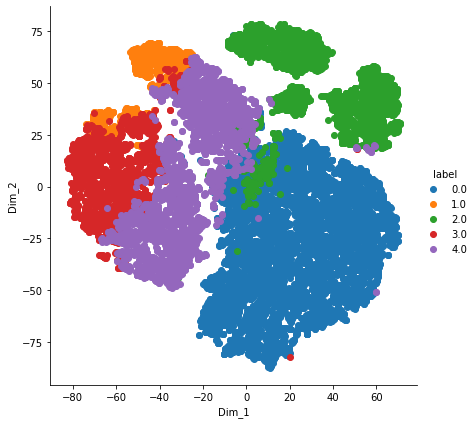

In [216]:
y_pred, k_means = c.train(H, 5)
tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(H)
tsne_data = np.vstack((tsne_data.T, y_pred)).T
tsne_df = pd.DataFrame(data = tsne_data,columns =("Dim_1", "Dim_2", "label"))
sns.FacetGrid(tsne_df, hue ="label", size = 6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [217]:
kpris = TopicModelling("Kpris")
text = kpris.get_text()
cluster_data = kpris.sort_data_to_clusters(text, y_pred)
tm = kpris.topic_models(cluster_data)
tmp = kpris.process_models(tm)

Directory already exists


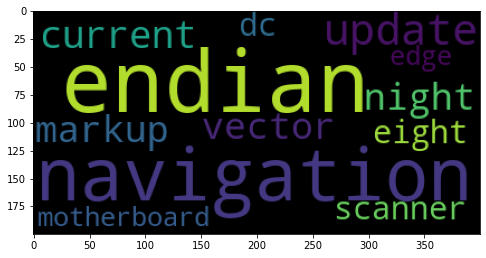

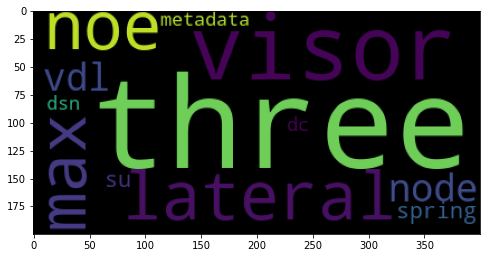

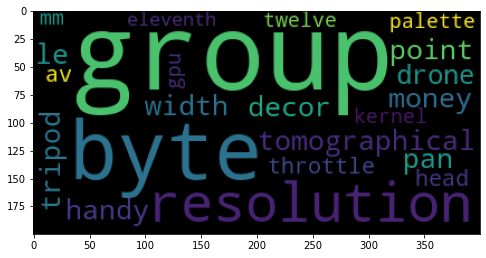

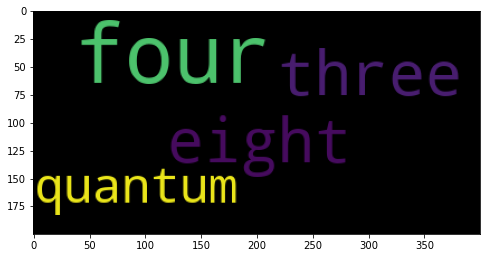

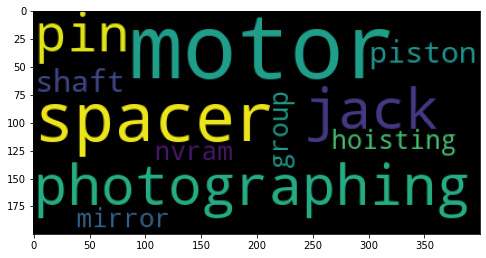

In [222]:
for i in range(5):
    data = ""
    for i in tmp[i]:
        data = data + " " + str(i)
    types = [str(ent.text) for ent in nlp(data) if ent.ent_type_ not in remove_ents]
    make_cloud(" ".join(types))

In [223]:
s

[0.433504,
 0.31318825,
 0.34764346,
 0.34375292,
 0.27971217,
 0.29211032,
 0.2961061,
 0.29452306,
 0.291455]